# UW-Madison GI Tract Image Segmentation

## Data analysis & visualisation

## Load libaries 📚

In [2]:
#!/usr/bin/env python

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import re
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from glob import glob

import tensorflow as tf


In [3]:
INPUT = (128,128,3)
HEIGHT = INPUT[0]
WIDTH = INPUT[1]
name = "efficientnet-b5_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
backbone = 'efficientnetb5'

BATCH_SIZE = 16
EPOCHS=1
N_SPLITS=5
SELECTED_FOLD=3 # 1..5
lr = 5e-4

In [4]:
%cd 'hpc_train_files'

/Users/viktor/Documents/BA/GIT/HealthyOrganTracker/hpc_train_files


In [5]:
from config import CFG
from dataloader import DataGenerator
from loss import dice_coef, iou_coef, dice_loss, bce_dice_loss
from datapreparation import extract_metadata, remove_faulties
from utility import rle_encode, rle_decode, build_masks, fix_empty_slices, is_isolated, fix_nc_slices

## Config ⚙️

In [6]:
BASE_PATH = 'input/uw-madison-gi-tract-image-segmentation/'
TRAIN_DIR =  BASE_PATH +'train'
TRAIN_CSV =  BASE_PATH +'train.csv'

"""
Backbones available: 
        'efficientnetb0'
        'efficientnetb5'
        'efficientnetb7'
        'inceptionresnetv2'
        'inceptionv3'
        'resnet50'
        'resnext50'
        'resnext101'
        'seresnext50'
        'seresnext101'
        'densenet121'
        'densenet201'
        """

"\nBackbones available: \n        'efficientnetb0'\n        'efficientnetb5'\n        'efficientnetb7'\n        'inceptionresnetv2'\n        'inceptionv3'\n        'resnet50'\n        'resnext50'\n        'resnext101'\n        'seresnext50'\n        'seresnext101'\n        'densenet121'\n        'densenet201'\n        "

In [7]:
df = pd.read_csv(TRAIN_CSV)
#df = df.sample(n=90, random_state=1)

In [8]:
cfg = CFG(
    backbone            = 'efficientnetb0',
    img_dims            = (32,32,3),
    model               = 'UNet',
    batch_size          = 16, 
    epochs              = 1, 
    kaggle              = False, 
    use_fold_csv        = True,
    semi3d_data         = True,
    remove_faulty_cases = True,
    use_crop_data       = True)

## Extract metadata

* Restructure frame
* Extract Case ID, Day and Slice
* Extract image path
* Extract image dimensions (width, height, pixelspacing)
* Extract amount of classes shown in slice

## 2.5D Data
* Adds depth to each slice
* Instead of a RGB channel we have: slice[0], slice[stride] amd slice[stride*2]

In [9]:
df_train = extract_metadata(df, TRAIN_DIR, channels=3, stride=2)

Frame merged. Shape: (38496, 21)
Remove faulty cases: True
Sucess. Shape: (38208, 21)


## Final table

In [12]:
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,case,day,slice,path,width,height,...,pixel_y,count,path00,path01,path02,image_paths,rs,re,cs,ce
4737,case22_day0_slice_0130,29648 4 29895 5 29908 12 30155 32 30419 34 304...,30757 8 31021 12 31285 16 31550 19 31815 22 32...,,22,0,130,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,2,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,43,10000,0,266
12108,case54_day30_slice_0029,,,,54,30,29,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,0,10000,0,266
5266,case29_day0_slice_0083,14178 10 14441 19 14705 24 14734 5 14969 38 15...,15551 17 15816 20 16080 24 16345 26 16608 31 1...,23504 4 23769 8 24035 10 24300 13 24565 15 248...,29,0,83,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,3,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,31,10000,0,266
8048,case36_day10_slice_0001,,,,36,10,1,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,33,10000,0,266
73,case2_day1_slice_0074,21203 2 21467 6 21732 9 21998 10 22263 12 2252...,,17978 9 18236 21 18501 23 18766 25 19032 26 19...,2,1,74,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,2,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,42,10000,0,266


## Exploratory Data Analysis

* 57% of the slices have no segmentation at all
* Left bowel is most segmented, stomach least

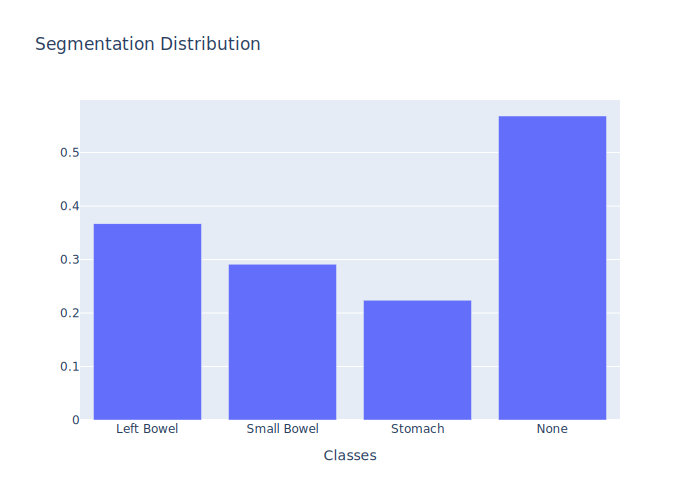

In [13]:
import plotly.graph_objects as go

dist = np.mean(df_train.iloc[:,1:4]!='',axis=0)
no_masks = np.sum(df_train['count'] == 0)/df_train.shape[0]
dist = np.append(dist.values, no_masks)

fig = go.Figure([go.Bar(x=['Left Bowel', 'Small Bowel', 'Stomach', 'None'], y=dist)])
fig.update_traces( textposition='outside')
fig.update_layout(title_text='Segmentation Distribution', xaxis_title="Classes")
fig.show("svg")

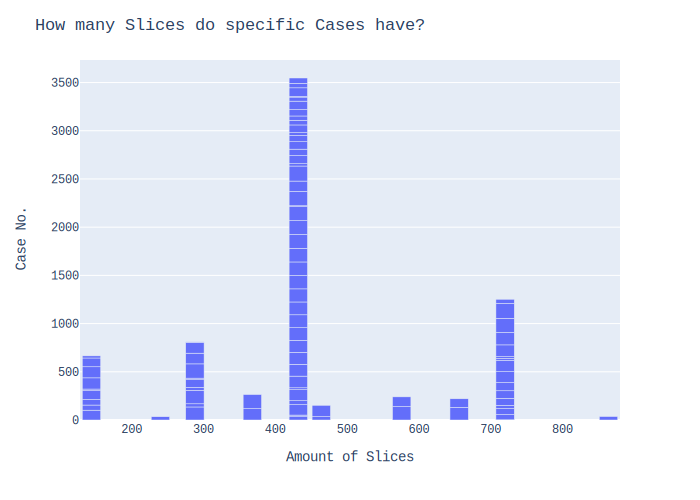

In [14]:
cases = df_train["case"].value_counts().reset_index()

fig = px.bar(cases, x='case', y='index')
fig.update_layout(
    font_family="Courier New",
    title="How many Slices do specific Cases have?",
    xaxis_title="Amount of Slices",
    yaxis_title="Case No.",
)

fig.show("svg")

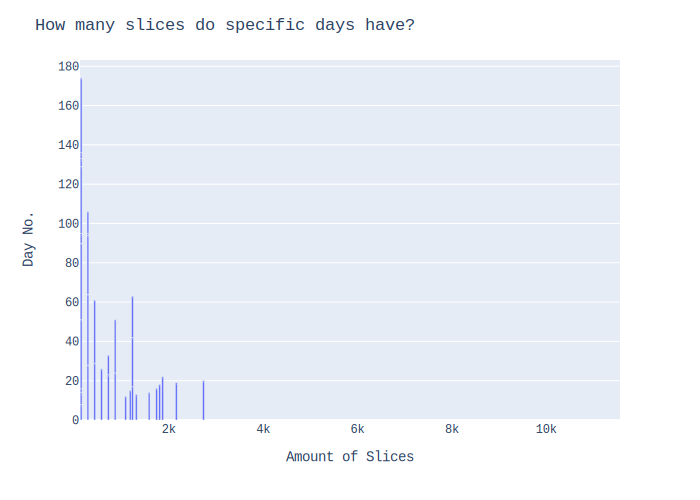

In [15]:
days = df_train["day"].value_counts().reset_index()

fig = px.bar(days, x='day', y='index', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    title="How many slices do specific days have?",
    xaxis_title="Amount of Slices",
    yaxis_title="Day No.",
)
fig.show("svg")

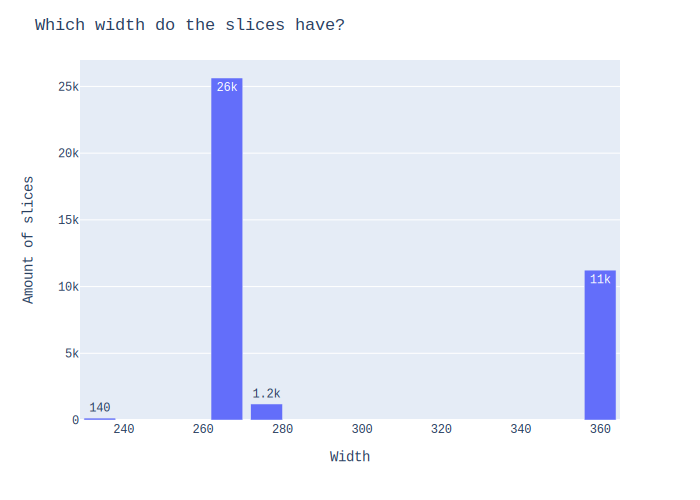

In [16]:
width = df_train["width"].value_counts().reset_index()

fig = px.bar(width, x='index', y='width', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    title="Which width do the slices have?",
    xaxis_title="Width",
    yaxis_title="Amount of slices",
)
fig.show("svg")

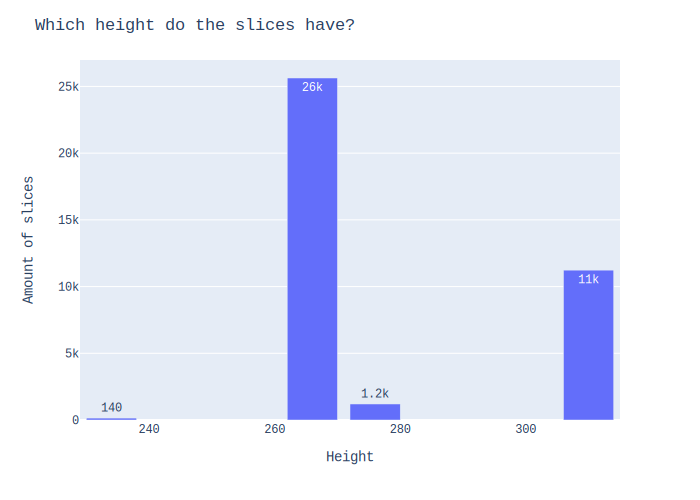

In [17]:
height = df_train["height"].value_counts().reset_index()

fig = px.bar(height, x='index', y='height', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    title="Which height do the slices have?",
    xaxis_title="Height",
    yaxis_title="Amount of slices",
)
fig.show("svg")

In [18]:
df_train["pixel_x"].value_counts().reset_index()

,index,pixel_x
0,1.50,37008
1,1.63,1200


In [19]:
df_train["pixel_y"].value_counts().reset_index()

,index,pixel_y
0,1.50,37008
1,1.63,1200


In [ ]:
# Next -> Display some slices + masks